# ConversationMemoryManagementSystem

- Author: [syshin0116](https://github.com/syshin0116)
- Design: 
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/06-DocumentLoader/13-LlamaParse.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/06-DocumentLoader/13-LlamaParse.ipynb)


## Overview

In modern AI systems, **memory management** plays a critical role in creating personalized and efficient user experiences. Imagine interacting with an AI that remembers nothing about your previous conversations—it would be frustrating to repeat the same information every time! To address this, memory management systems are designed to handle and organize information effectively.

This guide focuses on managing **Short-term** and **Long-term Memory** for conversational AI, specifically for building personalized chatbots. We will explore two implementation paths:

1. **Using LangGraph**: A structured and feature-rich framework for managing AI memory.
2. **Without LangGraph**: A more manual, flexible approach for situations where LangGraph is unavailable.


### What is Memory?

Memory in AI refers to the ability to **store, retrieve, and use information** during interactions. In conversational systems, memory can enhance user experience by:

- Adapting to user preferences
- Handling repetitive queries automatically
- Providing continuity across sessions

### Short-term vs Long-term Memory

|**Type**|**Scope**|**Purpose**|**Example**|
|---|---|---|---|
|**Short-term Memory**|Single conversational thread|Keeps track of recent interactions to provide immediate context|Remembering the last few messages in a chat|
|**Long-term Memory**|Shared across multiple threads and sessions|Stores critical or summarized information to maintain continuity across conversations|Storing user preferences, important facts, or conversation summaries|

- **Short-term Memory**: Ideal for maintaining the flow within a single conversation, like tracking the most recent messages.
- **Long-term Memory**: Useful for creating personalized experiences by recalling past interactions, preferences, or key facts over time.

## Table of Contents

두가지 안 중에 고민중입니다. 편의성을 위해 초안엔 ##, ### 모두 포함했습니다.

1안: LangGraph 사용법 더 자세히 설명

2안: LangGraph 사용 + 미사용

+ VectorDatabase 사용법도 추가하고 싶은 마음이 있습니다..시간되면..

TODO: 1안, 2안 결정 + ### 제거

### 1안, 2안 공통
- [Overview](#overview)
    - [What is Memory?](#what-is-memory)
    - [Short-term vs Long-term Memory](#short-term-vs-long-term-memory)
- [Environment Setup](#environment-setup)

### 1안

- [Construct Tool](#construct-tool)
- [Set Nodes for Memory Storage](#set-nodes-for-memory-storage)
- [Set Nodes for Agent](#set-nodes-for-agent)
- [Conditional Edge Logic](#conditional-edge-logic)
- [Load and Compile Graph](#load-and-compile-graph)
- [Visualize Graph](#visualize-graph)
- [Run Graph](#run-graph)

### 2안
- [Database Configuration](#database-configuration)
- [Short Term Memory](#short-term-memory)
    - [Checkpointer](#checkpointer)
    - [Filtering Long Conversation History](#trimming-long-conversation-history)
    - [Summarizing Conversations](#summarizing-conversations)
- [Long Term Memory](#long-term-memory)
    - [Storing Key Information](#storing-key-information)
- [Memory types](#memory-types)
    - [Semantic Memory](#semantic-memory)
    - [Episodic Memory](#episodic-memory)
    - [Procedural Memory](#proceduarl-memory)
- [Usecase Examples](#usecase-examples)
    - [Adapting to User Preferences](#adapting-to-user-preferences)
    - [LangGraph Flow Example](#langgraph-flow-example)

### References

- [LangGraph: What-is-memory](https://langchain-ai.github.io/langgraph/concepts/memory/#what-is-memory)
- [LangGraph: memory-template](https://github.com/langchain-ai/memory-template)
- [LangChain-ai: memory-agent](https://github.com/langchain-ai/memory-agent)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_community",
        "langchain_openai",
        "langgraph",
        "SQLAlchemy",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "09-ConversationMemoryManagementSystem",
    }
)

Environment variables have been set successfully.


In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Database Configuration

In this section, we will set up an **SQLite database** to store Short-term and Long-term Memory information for our chatbot. SQLite is a lightweight, serverless database that is easy to set up and ideal for prototyping or small-scale applications.


In [5]:
# SQLite Configuration

In [6]:
# SQLite Table Configuration

## Short Term Memory

Short-term memory lets your application remember previous interactions within a single thread or conversation. A thread organizes multiple interactions in a session, similar to the way email groups messages in a single conversation.

LangGraph manages short-term memory as part of the agent's state, persisted via thread-scoped checkpoints. This state can normally include the conversation history along with other stateful data, such as uploaded files, retrieved documents, or generated artifacts. By storing these in the graph's state, the bot can access the full context for a given conversation while maintaining separation between different threads.

Since conversation history is the most common form of representing short-term memory, in the next section, we will cover techniques for managing conversation history when the list of messages becomes long. If you want to stick to the high-level concepts, continue on to the [Long Term Memory](#long-term-memory) section.

### Checkpointer

In [7]:
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Union


def manage_list(existing: list, updates: Union[list, dict]):
    if isinstance(updates, list):
        # Normal case, add to the history
        return existing + updates
    elif isinstance(updates, dict) and updates["type"] == "keep":
        # You get to decide what this looks like.
        # For example, you could simplify and just accept a string "DELETE"
        # and clear the entire list.
        return existing[updates["from"] : updates["to"]]
    # etc. We define how to interpret updates


# Define State
class FilterState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # short term memory
    summary: list[dict]  # long term memory
    my_list: Annotated[list, manage_list]

In [8]:
# Load Checkpointer, In-emory storate
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

In [9]:
import uuid
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from typing import Annotated, Optional

## Construct Tool

In [10]:
from langchain_core.tools import InjectedToolArg, tool


@tool
def upsert_memory(
    content: str,
    context: str,
    memory_id: Optional[str] = None,
    *,
    config: Annotated[RunnableConfig, InjectedToolArg],
    store: Annotated[BaseStore, InjectedToolArg],
):
    """Upsert a memory in the database.

    If a memory conflicts with an existing one, then just UPDATE the
    existing one by passing in memory_id - don't create two memories
    that are the same. If the user corrects a memory, UPDATE it.

    Args:
        content: The main content of the memory. For example:
            "User expressed interest in learning about French."
        context: Additional context for the memory. For example:
            "This was mentioned while discussing career options in Europe."
        memory_id: ONLY PROVIDE IF UPDATING AN EXISTING MEMORY.
        The memory to overwrite.
    """
    mem_id = memory_id or uuid.uuid4()
    user_id = config["configurable"]["user_id"]
    store.put(
        ("memories", user_id),
        key=str(mem_id),
        value={"content": content, "context": context},
    )
    return f"Stored memory {content}"

## Set Nodes for Memory Storage

In [11]:
def store_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Extract tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    saved_memories = []
    for tc in tool_calls:
        content = tc["args"]["content"]
        context = tc["args"]["context"]
        saved_memories.append(
            [
                upsert_memory.invoke(
                    {
                        "content": content,
                        "context": context,
                        "config": config,
                        "store": store,
                    }
                )
            ]
        )
    print("saved_memories: ", saved_memories)

    results = [
        {
            "role": "tool",
            "content": mem[0],
            "tool_call_id": tc["id"],
        }
        for tc, mem in zip(tool_calls, saved_memories)
    ]
    print(results)
    return {"messages": results[0]}

## Set Nodes for Agent

In [12]:
model = ChatOpenAI(model="gpt-4o", temperature=0.7, streaming=True)

In [13]:
def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    memories = store.search(namespace)
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    if info:
        info = f"""
    <memories>
    {info}
    </memories>"""

    system_msg = f"""You are a helpful assistant talking to the user. You must decide whether to store information as memory from list of messages and then answer the user query or directly answer the user query
        User context info: {info}"""
    print("system_msg:", system_msg)
    # Store new memories if the user asks the model to remember
    last_message = state["messages"][-1]
    print([{"type": "system", "content": system_msg}] + state["messages"])
    response = model.bind_tools([upsert_memory]).invoke(
        [{"type": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}

## Conditional Edge Logic

In [14]:
def route_message(state: MessagesState):
    """Determine the next step based on the presence of tool calls."""
    msg = state["messages"][-1]
    if msg.tool_calls:
        # If there are tool calls, we need to store memories
        return "store_memory"
    # Otherwise, finish; user can send the next message
    return END

## Load and Compile Graph

In [15]:
builder = StateGraph(MessagesState)

builder.add_node("call_model", call_model)
builder.add_node(store_memory)

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", route_message, ["store_memory", END])
builder.add_edge("store_memory", "call_model")

graph = builder.compile(store=in_memory_store)

## Visualize Graph

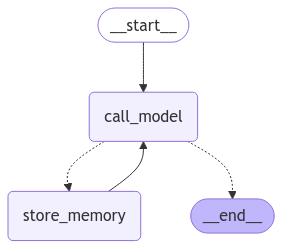

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run graph

In [17]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
input_message = {
    "type": "user",
    "content": "Hi! My name is LangChain. I love keep updated on Latest Tech",
}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is LangChain. I love keep updated on Latest Tech
system_msg: You are a helpful assistant talking to the user. You must decide whether to store information as memory from list of messages and then answer the user query or directly answer the user query
        User context info: 
[{'type': 'system', 'content': 'You are a helpful assistant talking to the user. You must decide whether to store information as memory from list of messages and then answer the user query or directly answer the user query\n        User context info: '}, HumanMessage(content='Hi! My name is LangChain. I love keep updated on Latest Tech', additional_kwargs={}, response_metadata={}, id='2e3fa22d-fb38-496b-9fc1-355cbb716077')]
================================== Ai Message ==================================
Tool Calls:
  upsert_memory (call_HzLinSecG8ZvN2JY2Ul9GzE3)
 Call ID: call_HzLinSecG8ZvN2JY2Ul9GzE3
  Args:
    conte